<a href="https://colab.research.google.com/github/embarced/notebooks/blob/master/deep/rl_odsc_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Dive into Reinforcement Learning with PPO using TF-Agents & TensorFlow

3 hours

https://odsc.com/speakers/deep-dive-into-reinforcement-learning-with-ppo-using-tf-agents-tensorflow-2-0/

Link to this notebook: https://bit.ly/rl-odsc-2021

# Iteration 0: Preparation

1. Make sure you are ready to work with Colab
  * open https://colab.research.google.com/notebooks/welcome.ipynb in Chrome (IE will not work)
  * make it run using the "Run All" command from the "Runtime" menu
  * you need to allow execution and must either have a Google login or are willing to create one
  * Log into your Google Account or create one when prompted do so so by the 
  * Go through the notebook and make yourself comfortable with Colab
1. Get Access to this notebook
  * https://bit.ly/rl-odsc-2021
  * Open this notebook in Chrome
  * Make a copy to your Google Drive (File->Save a Copy in Drive)
  * Rename it to something more speaking

# Iteration 1: Getting to know the notebook and going through it in sync

**Going through notebook high level**

1. Understand our use case
1. Idea of Reinforcement Learning with PPO
1. Our first training run


# Iteration 2: Hands-On train your own RL model

**Getting your hands dirty**

## Option 1: tweak agent and training

* Be careful, Reinforcement Learning is notoriously unstable
* Change one parameter at a time
* If training does not work any more, reverse

### Parameters to tune
#### Basic
* Tweak Value and Policy Network
  * Number of layers and neurons in them
  * Dropout
* number of training iterations

#### Advanced
* Adapt PPO Agent Parameters
  * Impact of entropy loss
  * Explore all parameters of PPO
* Change Optimizer and/or learning rate
* Change whatever you think has an impact

## Option 2: experiment with different modeling of environment
1. staying home becomes an option - "no move" is a valid action
1. no penalty for invalid move (walk out of world)
1. change rewards
1. change observation


# Iteration 3: Advanced

**Going through the PPO part more low level**

1. Making sense of losses
1. PPO learning still is hard to stabilize
  * Out of all the machine learning stuff, deep reinforcement learning requires the least tuning and works out of box😊 (https://twitter.com/vwxyzjn/status/1449907113799602180) 
1. GAE, an alternative method to calculate reward

## More Resources

1. https://spinningup.openai.com/en/latest/algorithms/ppo.html
* PPO from scratch
  * https://keras.io/examples/rl/ppo_cartpole/
  * https://github.com/higgsfield/RL-Adventure-2/blob/master/3.ppo.ipynb
* The scientific paper for PPO: https://arxiv.org/abs/1707.06347
* A3C paper, explains several basic techniques such as the utility of the Critic and the additional entropy loss-term: https://arxiv.org/abs/1602.01783
* TF-Agents
  * https://www.tensorflow.org/agents
  * https://github.com/tensorflow/agents
  * https://www.tensorflow.org/agents/tutorials/5_replay_buffers_tutorial
* https://arxiv.org/abs/2110.00641

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 12)
# mpl.rcParams["figure.dpi"] = 300
mpl.__version__

'3.3.4'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# tf-agents should match version of TF
# https://github.com/tensorflow/agents

import sys
if 'google.colab' in sys.modules:
    !pip install -q tf-agents[reverb]==0.7.1 2>/dev/null

    !apt-get update >/dev/null
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 
    !pip install -q networkx 2>/dev/null
    !pip install imageio-ffmpeg

In [4]:
import tf_agents
tf_agents.__version__

'0.7.1'

In [5]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [6]:
tf.random.set_seed(42)

In [7]:
!nvidia-smi

Sun Nov 14 09:23:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.50       Driver Version: 471.21       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8    12W /  N/A |    193MiB / 16384MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import tensorflow_probability as tfp
tfp.__version__

'0.13.0'

In [9]:
import networkx as nx
nx.__version__

'2.6.2'

# Step I: The application: Guide the bear through feeding time

In [10]:
import gym
from gym import spaces
import matplotlib.image as mpi
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from IPython.display import display, clear_output
import numpy as np
import random

graph = {
            'S': [('A', 300), ('B', 100), ('C', 200)],
            'A': [('S', 300), ('B', 100), ('E', 100), ('D', 100)],
            'B': [('S', 100), ('A', 100), ('C', 50), ('K', 200)],
            'C': [('S', 200), ('B', 50), ('M', 100), ('L', 200)],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }

def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]

class OrsoEnv(gym.Env):
    metadata = {'render.modes': ['ansi']}
    showStep = False

    def __init__(self):
        self.map = graph
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)

        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)
        self.reward_range = (-1, 1)
        self.envEpisodeCount = 0
        self.envStepCount = 0
        self._figure = None

        self.reset()
        self.optimum = self.calculate_customers_reward()

        base = "https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/img/rl/graph/"
        self.image_orso = mpi.imread(base + "Orso.png")
        self.image_cave = mpi.imread(base + "Cave.png")
        self.image_honey = mpi.imread(base + "Honey.png")
        self.image_empty_pot = mpi.imread(base + "EmptyPot.png")
        self.nx_graph, self.nx_pos = self._create_nx_graph()

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
            return paths[action]
        else:
            # sorry, no such action, stay where you are and pay a high penalty
            return (state, 1000)

    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)
        source = self.state

        self.cost = cost
        self.action = action
        self.lastStep_state = self.state
        self.state = destination
        self.customerReward = self.customer_reward[destination]
        self.reward = 0
        self.reward = (self.customerReward - self.cost) / self.optimum

        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += self.reward
        self.stepCount += 1
        self.envStepCount += 1

        if done and not self.isDone:
            self.envEpisodeCount += 1

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": source, "to": destination}
        return observation, self.reward, done, info

    def getObservation(self, position):
        result = np.array([position,
                           self.getPathObservation(position, 0),
                           self.getPathObservation(position, 1),
                           self.getPathObservation(position, 2),
                           self.getPathObservation(position, 3)
                           ],
                          dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        paths = self.map[self.state]
        if path < len(paths):
            target, cost = paths[path]
            reward = self.customer_reward[target]
            result = reward - cost
        else:
            result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

    # each node gets a reward, either 0 or 10000
    def modulate_reward(self):
        self.customer_reward = {}

        node_names = list(self.map.keys())
        # initialize all nodes with 0
        for node_name in node_names:
            self.customer_reward[node_name] = 0

        # 10000 rewards are only at a few random places
        number_of_customers = len(self.map) - 1
        number_per_consultant = int(number_of_customers / 2)
        self._honeypot_places = []

        # starting from 1, not 0, so that 'S' (position of the cave) never gets a reward 
        samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
        for sample in samples:
            self.customer_reward[node_names[sample]] = 1000
            self._honeypot_places = self._honeypot_places + [node_names[sample]]

    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        self.state = 'S'
        self.cost = 0
        self.action = 0
        self.lastStep_state = ''
        self.customerReward = None
        self._honeypot_places = None
        self.reward = 0
        self.envEpisodeCount += 1
        self.modulate_reward()
        self._figure = None
        return self.getObservation(state_name_to_int(self.state))

    def _create_nx_graph(self):
        """ generates the networkx graph representing orso's world with all its paths.

        :return: graph, positions
        """
        nx_graph = nx.Graph()
        for node_id in self.map.keys():
            zoom = 0.6
            image = self.image_empty_pot
            nx_graph.add_node(node_id, image=image, zoom=zoom)
        for source, connections in self.map.items():
            for action, (target, cost) in enumerate(connections):
                if cost >= 300:
                    color = 'dodgerblue'
                elif cost >= 200:
                    color = 'darkgoldenrod'
                elif cost >= 100:
                    color = 'forestgreen'
                else:
                    color = 'greenyellow'
                directed_label = str(source) + ":" + str(action)
                existing_edge = nx_graph.get_edge_data(source, target)
                if existing_edge is not None: 
                    directed_label = str(existing_edge['label']) + ' - ' + directed_label
                nx_graph.add_edge(source, target, color=color, weight=6, cost=cost, label=directed_label, image=self.image_cave)
        nx_pos = nx.kamada_kawai_layout(nx_graph)
        return nx_graph, nx_pos

    def _render_to_figure(self, render_graph_labels=False, render_costs=False):
        """ Renders the current state as a graph with matplotlib
        """
        # draw graph using matplotlib
        if (self._figure is not None):
            plt.close(self._figure)
        self._figure = plt.figure()
        if len(self._figure.axes) == 0:
            self._figure.add_subplot(1, 1, 1)
        self._figure.axes[0].cla()
        ax = self._figure.axes[0]

        edges = self.nx_graph.edges()
        edge_colors = [self.nx_graph[u][v]['color'] for u, v in edges]
        edge_weights = [self.nx_graph[u][v]['weight'] for u, v in edges]

        nx.draw_networkx(self.nx_graph, pos=self.nx_pos, ax=ax, node_color='lightgrey',
                edgelist=edges, edge_color=edge_colors, width=edge_weights, with_labels=render_graph_labels)

        if render_graph_labels:
          edge_labels = [self.nx_graph[u][v]['label'] for u, v in edges]
          zipped_edge_labels = dict(zip(edges, edge_labels))
          nx.draw_networkx_edge_labels(self.nx_graph, pos=self.nx_pos, ax=ax, edge_labels=zipped_edge_labels)

        if render_costs:
          edge_costs = [self.nx_graph[u][v]['cost'] for u, v in edges]
          zipped_edge_labels = dict(zip(edges, edge_costs))
          nx.draw_networkx_edge_labels(self.nx_graph, pos=self.nx_pos, ax=ax, edge_labels=zipped_edge_labels)

        # draw images on graph nodes
        # set image (according to the current state) and sizes (make orso's current position larger)
        for node_id in self.nx_graph.nodes():
            node = self.nx_graph.nodes[node_id]
            node['zoom'] = 0.4
            if node_id == self.state:
                node['zoom'] = 0.6
            if node_id in self._honeypot_places:
                node['image'] = self.image_empty_pot
                if self.customer_reward[node_id] > 0:
                    node['image'] = self.image_honey
            else:
                node['image'] = None
            if node_id == 'S':
                node['image'] = self.image_cave
            if self.state == node_id:
                node['image'] = self.image_orso

        # position images
        for n in self.nx_pos:
            node = self.nx_graph.nodes[n]
            image = node['image']
            if image is not None: 
                xp, yp = self.nx_pos[n]
                offset_image = OffsetImage(image, node['zoom'])
                offset_image.image.axes = ax
                ab = AnnotationBbox(offset_image, (xp, yp),
                                    xybox=(0, 0),
                                    xycoords='data',
                                    boxcoords="offset points",
                                    pad=0.0,
                                    frameon=False
                                    )
                ax.add_artist(ab)

        self._figure.canvas.draw()

    def _render_ansi(self):
        result = ("Episode: " + ("%4.0f  " % self.envEpisodeCount) +
                  " Step: " + ("%4.0f  " % self.stepCount) +
                  self.lastStep_state + ' --' + str(self.action) + '-> ' + self.state +
                  ' R=' + ("% 2.2f" % self.reward) + ' totalR=' + ("% 3.2f" % self.totalReward) +
                  ' cost=' + ("%4.0f" % self.cost) + ' customerR=' + ("%4.0f" % self.customerReward) + ' optimum=' + (
                          "%4.0f" % self.optimum)
                  )
        return result

    def _render_rgb(self):
        self._render_to_figure()
        self._figure.canvas.draw()
        buf = self._figure.canvas.tostring_rgb()
        num_cols, num_rows = self._figure.canvas.get_width_height()
        plt.close(self._figure)
        self._figure = None
        result = np.fromstring(buf, dtype=np.uint8).reshape(num_rows, num_cols, 3)
        return result

    def render(self, mode='human', render_graph_labels=False, render_costs=False):
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'human':
            clear_output(wait=True)
            self._render_to_figure(render_graph_labels=render_graph_labels, render_costs=render_costs)
            plt.pause(0.01)
            return
        elif mode == 'rgb_array':
            return self._render_rgb()
        else:
            super().render(mode=mode)

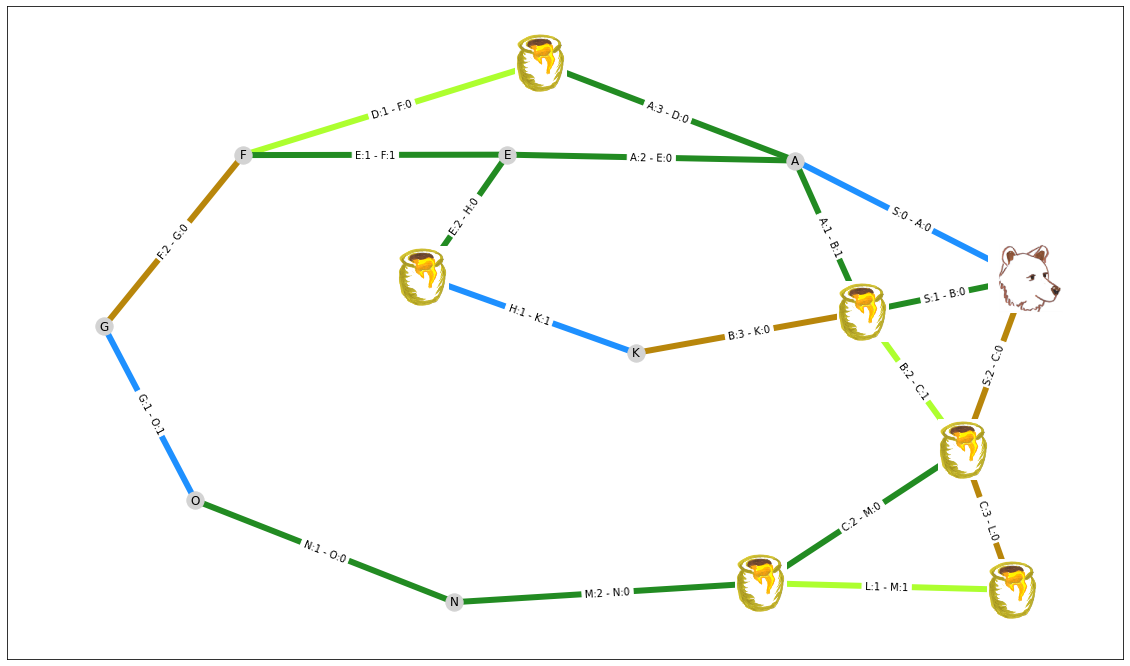

In [11]:
mpl.rcParams['figure.figsize'] = (20, 12)

env = OrsoEnv()
env.render(render_graph_labels=True)

In [12]:
### after each step in a certain directon we get
# 1. the new observation (we will talk about this later)
# 1. the reward for this step/action normalized to 1
# 1. if the game is done (bear needs to collect all honey and return to its cave)
# 1. additional information

observation, reward, done, info = env.step(1)
reward, done, info

(0.15, False, {'from': 'S', 'to': 'B'})

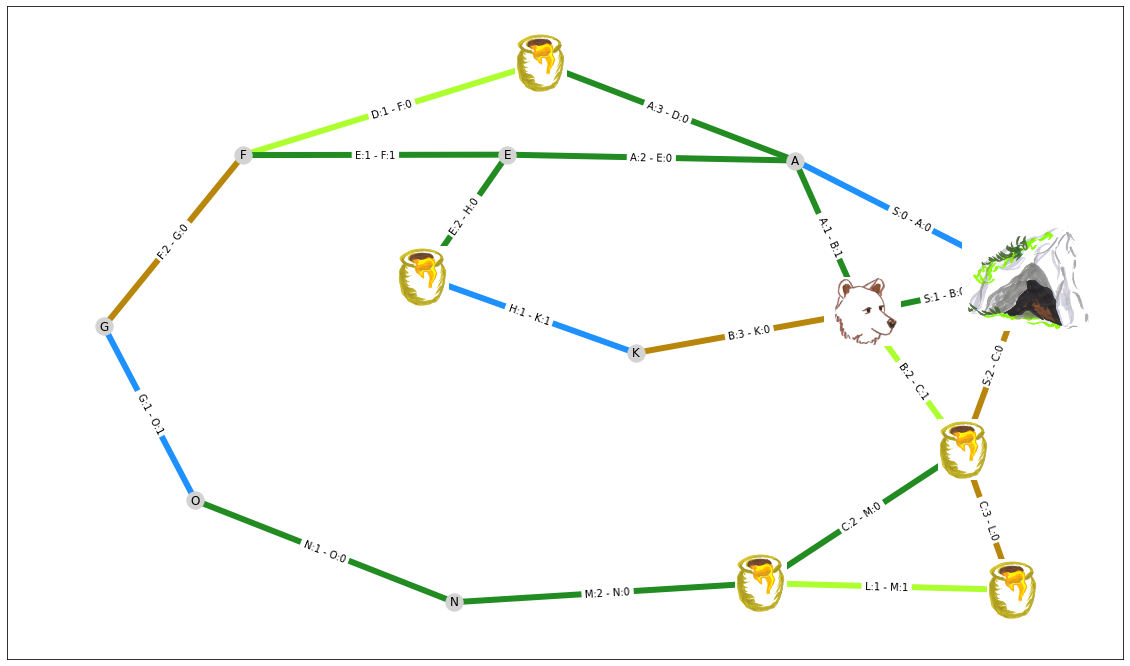

In [13]:
env.render(render_graph_labels=True)

# Step II: Tackling the problem with Reinforcement Learning

## Idea of Reinforcement Learning

<div class="container">
<div class="col">
    <img src='https://embarced.github.io/ml-concepts/img/rl2/rl.png' style="height: 300px;">

</div>    
<div class="col">
    <br>
<ol>
    <li>Based on <em>Observations</em> an <em>Agent</em> executes </li>
<li> <em>Actions</em> within a given  
<li><em>Environment</em> which lead to positive or negative 
<li><em>Rewards</em>.
</ol>
</div>    
</div>
The Agent’s job is to maximize the cumulative Reward

http://gym.openai.com/docs/



## Modelling the observation and the reward are crucial

In [14]:
observation = env.reset()

# a flat vector consisting of
# 1. position of bear
# 1. 4 combined rewards (cost of travel plus potential honey reward) of the four paths the bear can choose
# 1. 14 values for each node, 1000 if there still is honey there, 0 otherwise
observation

array([    0.,  -300.,   900.,   800., -1000.,     0.,     0.,  1000.,
        1000.,     0.,  1000.,     0.,  1000.,     0.,  1000.,     0.,
           0.,     0.,  1000.])

In [15]:
observation, reward, done, info = env.step(1)
observation

array([   2., -100., -100.,  950.,  800.,    0.,    0.,    0., 1000.,
          0., 1000.,    0., 1000.,    0., 1000.,    0.,    0.,    0.,
       1000.])

In [16]:
reward, done, info

(0.15, False, {'from': 'S', 'to': 'B'})

# Step III: PPO

## There are a lot of algorithms

<img src='https://spinningup.openai.com/en/latest/_images/rl_algorithms_9_15.svg'>

https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html    


## For practical work PPO is the algorithm to choose when creating samples is inexpensive

* if samples are expensive SAC might be best choice
* for our example sampling is cheap

https://spinningup.openai.com/en/latest/algorithms/ppo.html


### PPO (Proximal Policy Optimization)

<img src='https://embarced.github.io/ml-concepts/img/rl2/ppo.png'>


## PPO uses two networks

<img src='https://embarced.github.io/ml-concepts/img/rl2/drl-ppo.png'>

In [17]:
from tf_agents.environments import suite_gym, tf_py_environment

env_name="Orso-v1"

env = gym.envs.registration.register(id=env_name,entry_point=OrsoEnv, max_episode_steps=25)

# two envs for train and eval
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

# converted to tf-agents tensorflow envs
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)          

## Value Network


In [18]:
from tf_agents.networks import value_network, actor_distribution_network

value_net = value_network.ValueNetwork(
    train_env.observation_spec(), 
    fc_layer_params=(500, 500, 500),
    # dropout_layer_params=(0.2, 0.2, 0.2)
    )

In [19]:
time_step = train_env.reset()
observation = time_step.observation
value_net(observation)[0].numpy()

array([9.886841], dtype=float32)

## Policy Network

In [20]:
# data changes all the time, so risk to overfit is smaller than 
# in pure supervised training, but it might still bring a benefit and does not cost us much:
# https://openai.com/blog/quantifying-generalization-in-reinforcement-learning/
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(500, 500, 500),
    # dropout_layer_params=(0.2, 0.2, 0.2)
    )

In [21]:
# https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical
distribution, _ = actor_net(observation[0], time_step.step_type, ())
distribution.logits.numpy()

array([ -5.1062407, -21.48516  ,   5.717899 ,  23.892035 ], dtype=float32)

In [22]:
# greedy, highest category
distribution.mode().numpy()

3

## What you need using tf-agents while training

![TF-Agents overview](https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/talk/tf-agents-overview.png?raw=1)

https://www.youtube.com/watch?v=tAOApRQAgpc
<br>
https://www.youtube.com/watch?v=-TTziY7EmUA

## <a href='https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/talk/tf-agents-overview.png?raw=1' target='_blank'>Open in new window to view side by side with code</a>

## PPO uses both Networks

In [23]:
# https://github.com/tensorflow/agents/blob/master/tf_agents/agents/ppo/ppo_agent.py

from tf_agents.agents.ppo import ppo_agent

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # default is 1e-3

tf_ppo_agent = ppo_agent.PPOAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_net=actor_net,
    value_net=value_net,
    optimizer=optimizer,
    use_gae=False, # just subtract value predictions from empirical return to calculate advantage
    entropy_regularization=0.01, # switched off by default, but we really want to boost initial exploration
    num_epochs=10) # 25 by default, but we see better results with more frequent updates of the training data
tf_ppo_agent.initialize()

In [24]:
# ppo_agent.PPOAgent?

# Step IV: Configure data collection for phase 2

In [25]:
# https://www.tensorflow.org/agents/tutorials/5_replay_buffers_tutorial

# batch_size = 32
batch_size = 1
max_length = 10001

In [26]:
from tf_agents.metrics import tf_metrics
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.utils import common

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_ppo_agent.collect_data_spec,
    batch_size=batch_size,
    max_length=max_length)

avg_return = tf_metrics.AverageReturnMetric()
avg_length = tf_metrics.AverageEpisodeLengthMetric()

collect_driver = DynamicEpisodeDriver(train_env,
                                      tf_ppo_agent.collect_policy,
                                      observers=[replay_buffer.add_batch, avg_return, avg_length],
                                      num_episodes=10)
# just for optimized execution
tf_ppo_agent.train = common.function(tf_ppo_agent.train)
collect_driver.run = common.function(collect_driver.run)

# Step V: Training Loop

1. collect data by playing
1. train with that data
1. erase all data 
1. repeat for a number of iterations

<img src='https://embarced.github.io/ml-concepts/img/rl2/ppo.png'>


In [27]:
num_iterations =   500# @param {type:"integer"}
log_interval = 25 # @param {type:"integer"}

In [28]:
%%time

losses = []
policy_gradient_losses = []
value_estimation_losses = []
kl_losses = []
entropy_losses = []

returns = []
lengths = []

for iteration in range(num_iterations):
    
    # 1. collect data by playing
    collect_driver.run()
    # FIXME: this is deprecated rather do
    # as_dataset(..., single_deterministic_pass=True)
    trajectories = replay_buffer.gather_all()
    
    # 2. train with a new set of trajectories
    loss_info = tf_ppo_agent.train(trajectories)
    # 3. and clear afterwards
    replay_buffer.clear()

    # 4. just tracking of losses and other metrics
    total_loss = loss_info.loss.numpy()
    losses.append(total_loss)

    policy_gradient_loss = loss_info.extra.policy_gradient_loss.numpy()
    policy_gradient_losses.append(policy_gradient_loss)
    
    value_estimation_loss = loss_info.extra.value_estimation_loss.numpy()
    value_estimation_losses.append(value_estimation_loss)

    kl_loss = loss_info.extra.kl_penalty_loss.numpy()
    kl_losses.append(kl_loss)

    entropy_losses.append(loss_info.extra.entropy_regularization_loss.numpy())

    returns.append(avg_return.result().numpy())
    lengths.append(avg_length.result().numpy())    

    # logging
    step = tf_ppo_agent.train_step_counter.numpy()
    if step % log_interval == 0:
        print('iteration = {0} / step = {1}: loss = {2}, avg return = {3}, avg length = {4}'.format(
            iteration, step, total_loss, avg_return.result().numpy(), avg_length.result().numpy()))

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.
iteration = 4 / step = 50: loss = 6.269886016845703, avg return = -0.5158333778381348, avg length = 25.0
iteration = 9 / step = 100: loss = 2.4308676719665527, avg return = -0.40833336114883423, avg length = 25.0
iteration = 14 / step = 150: loss = 1.2968344688415527, avg return = -0.21916672587394714, avg length = 25.0
iteration = 19 / step = 200: loss = 2.28140926361084, avg return = 0.07416661828756332, avg length = 25.0
iteration = 24 / step = 250: loss = 2.4265360832214355, avg return = 0.25583332777023315, avg length = 24.200000762939453
iteration = 29 / step = 300: loss = 3.5401217937469482, avg return = 0.37000003457069397, avg length = 23.399999618530273
iteration = 34 / step = 350: loss = 1.6942533254623413, avg return = 0.2866666316986084, avg length = 24.700000762939453
iteration = 39 / step = 400: loss = 1.7543390989303589, avg return = 0.38749995827674866, avg length = 24.29999923706

iteration = 339 / step = 3400: loss = 0.5435020923614502, avg return = 0.6808334589004517, avg length = 16.100000381469727
iteration = 344 / step = 3450: loss = 1.120867371559143, avg return = 0.5958333611488342, avg length = 19.0
iteration = 349 / step = 3500: loss = 0.7432935833930969, avg return = 0.6125000715255737, avg length = 18.5
iteration = 354 / step = 3550: loss = 0.40738970041275024, avg return = 0.660833477973938, avg length = 18.0
iteration = 359 / step = 3600: loss = 0.42118459939956665, avg return = 0.6449999809265137, avg length = 16.899999618530273
iteration = 364 / step = 3650: loss = 0.728400707244873, avg return = 0.6550000309944153, avg length = 16.600000381469727
iteration = 369 / step = 3700: loss = 0.5148782730102539, avg return = 0.6766667366027832, avg length = 17.399999618530273
iteration = 374 / step = 3750: loss = 1.226889729499817, avg return = 0.627500057220459, avg length = 17.5
iteration = 379 / step = 3800: loss = 0.327195405960083, avg return = 0.685

# Step VI: Losses and Metrics

## Special Loss in PPO

* most advanced and practical variant of policy gradient branch
* uses vanilla backpropagation for training
* has special loss consisting of many parts
* turns hard constraints into penalties 
* uses value function to have better generalization

## Losses

* Policy Loss: which action to perform
* Value Loss: prediction of reward
* KL Loss: prevent catatrophic updates
* Entropy Loss: trade exploitation for exploration over time

In [29]:
mpl.rcParams['figure.figsize'] = (20, 12)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

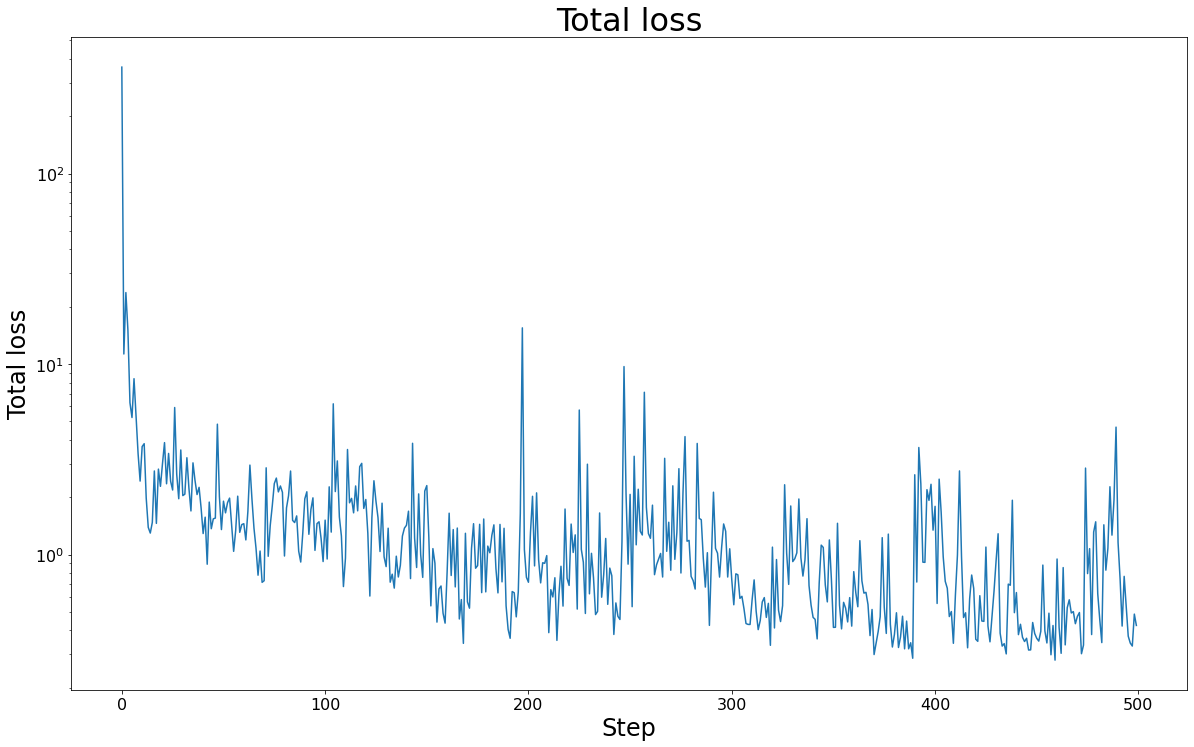

In [30]:
plt.yscale('log')
plt.plot(losses)
plt.title('Total loss')
plt.ylabel('Total loss')
plt.xlabel('Step');

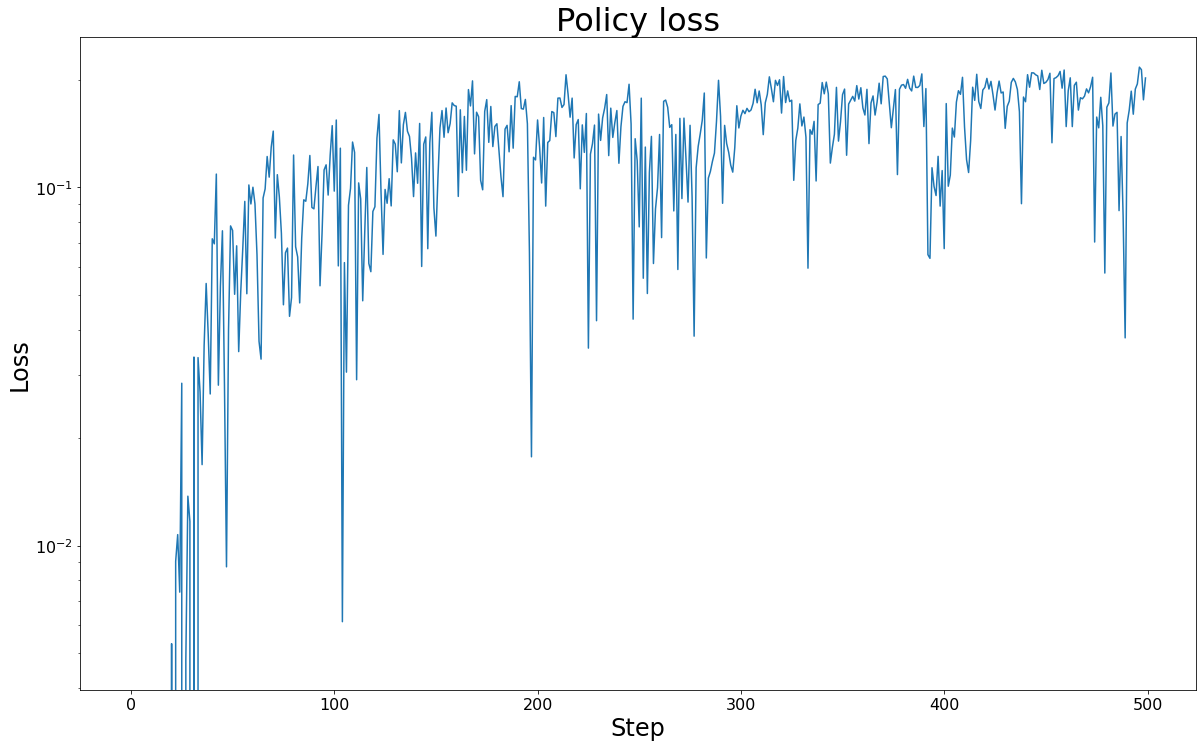

In [31]:
plt.plot(policy_gradient_losses)
plt.title('Policy loss')
plt.ylabel('Loss')
plt.xlabel('Step');
plt.yscale('log')


## Value Loss: prediction of reward

A3C paper, explains several basic techniques such as the utility of the Critic and the additional entropy loss-term: https://arxiv.org/abs/1602.01783


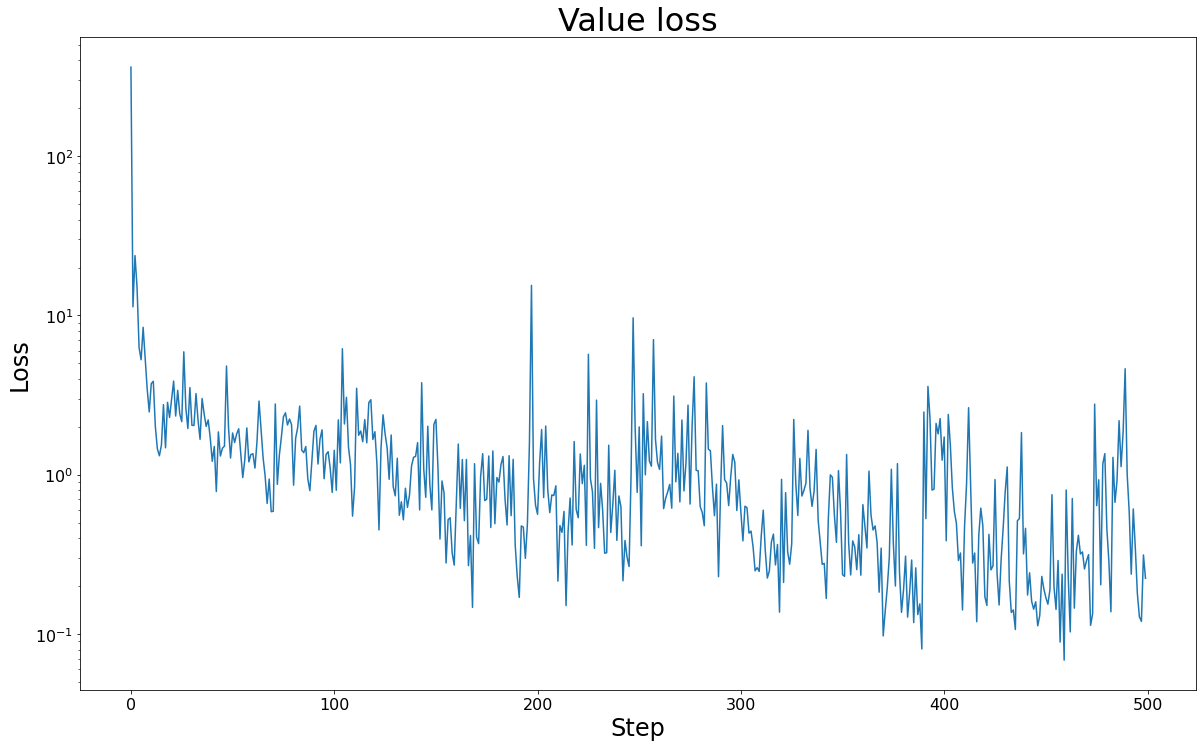

In [32]:
plt.plot(value_estimation_losses)
plt.title('Value loss')
plt.ylabel('Loss')
plt.xlabel('Step');
plt.yscale('log')

## KL Loss: prevent catatrophic updates

Policy gradient-based methods for reinforcement learning have enjoyed great success in recent years.
The stability and reliability of these methods is typically improved by controlling the size of policy
updates, using either a “trust region” (TRPO) or a surrogate objective (PPO).

The usual justification for this is that we cannot trust updates that take us too far from the
policy used to collect experience, called the behavior policy.

https://arxiv.org/pdf/2110.00641.pdf

---

While this kind of clipping goes a long way towards ensuring reasonable policy updates, it is still possible to end up with a new policy which is too far from the old policy, and there are a bunch of tricks used by different PPO implementations to stave this off. In our implementation here, we use a particularly simple method: early stopping. If the mean KL-divergence of the new policy from the old grows beyond a threshold, we stop taking gradient steps.

https://spinningup.openai.com/en/latest/algorithms/ppo.html#quick-facts

### KL Divergence in PPO

_we don’t want any new policy to be too different from the current one_

* a measure of how difference of two probability distributions
    * https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
* Penalize big changes in the action distribution from policy network 
* Adding KL Divergence as part of the loss function
* Makes it accessible to standard first order optimizers in NN backpropagation
  * https://medium.com/@jonathan_hui/rl-proximal-policy-optimization-ppo-explained-77f014ec3f12


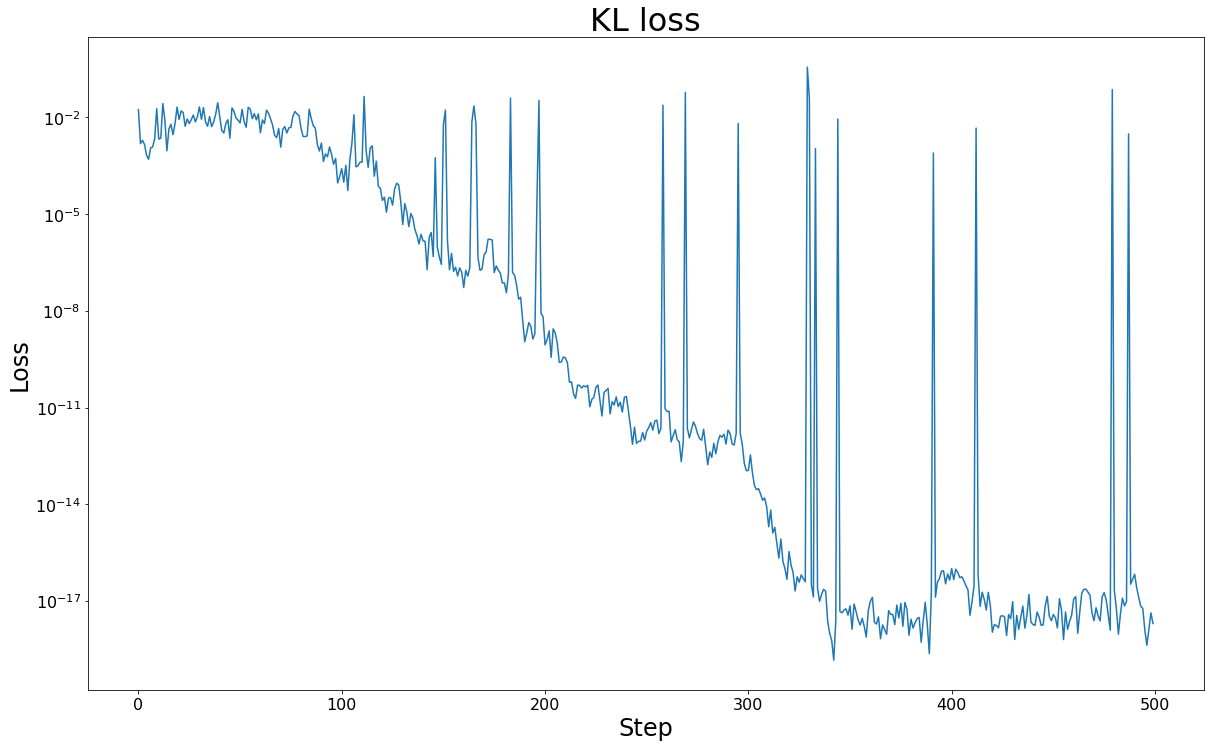

In [33]:
plt.plot(kl_losses)
plt.title('KL loss')
plt.ylabel('Loss')
plt.xlabel('Step');
plt.yscale('log')

In [45]:
plt.yscale?

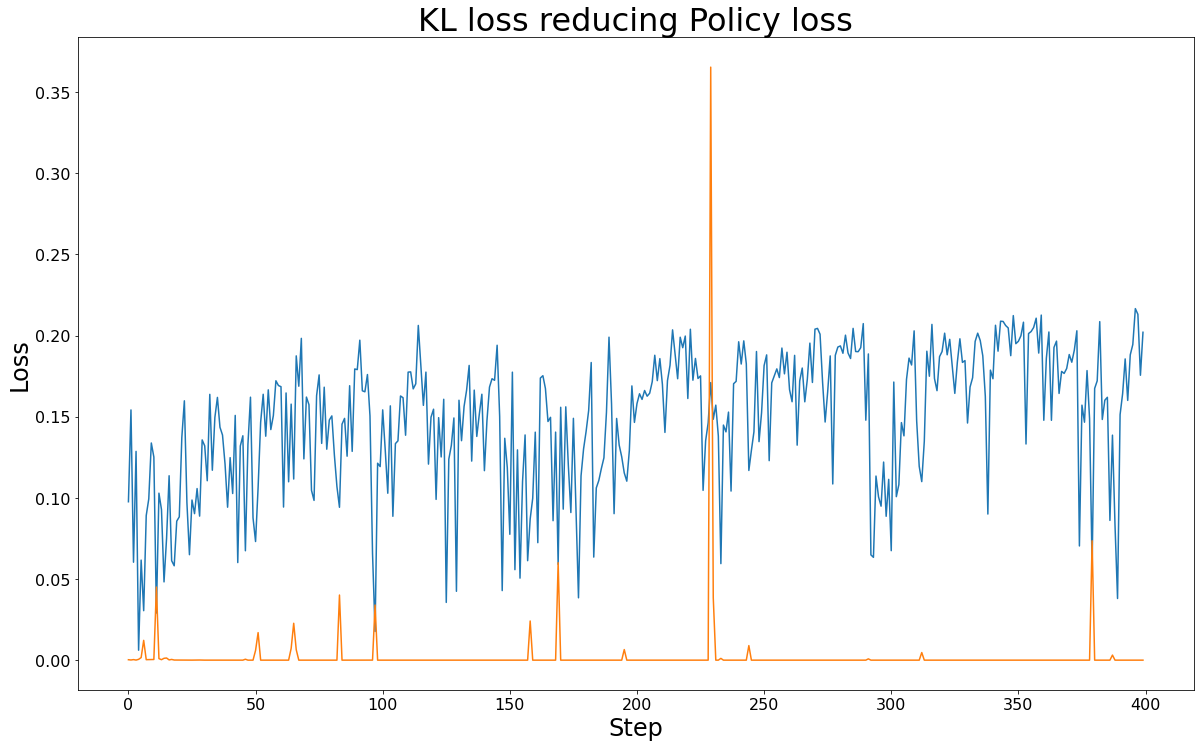

In [61]:
plt.title('KL loss reducing Policy loss')
plt.ylabel('Loss')
plt.xlabel('Step')

start_epoch = 100

# plt.yscale('log')
plt.plot(policy_gradient_losses[start_epoch:])
# plt.yscale('linear')
plt.plot(kl_losses[start_epoch:]);

## Entropy Loss: trade exploitation for exploration over time

A3C paper, explains several basic techniques such as the utility of the Critic and the additional entropy loss-term: https://arxiv.org/abs/1602.01783

---

objective can further be augmented by adding an entropy bonus to ensure sufficient exploration

https://arxiv.org/pdf/1707.06347.pdf

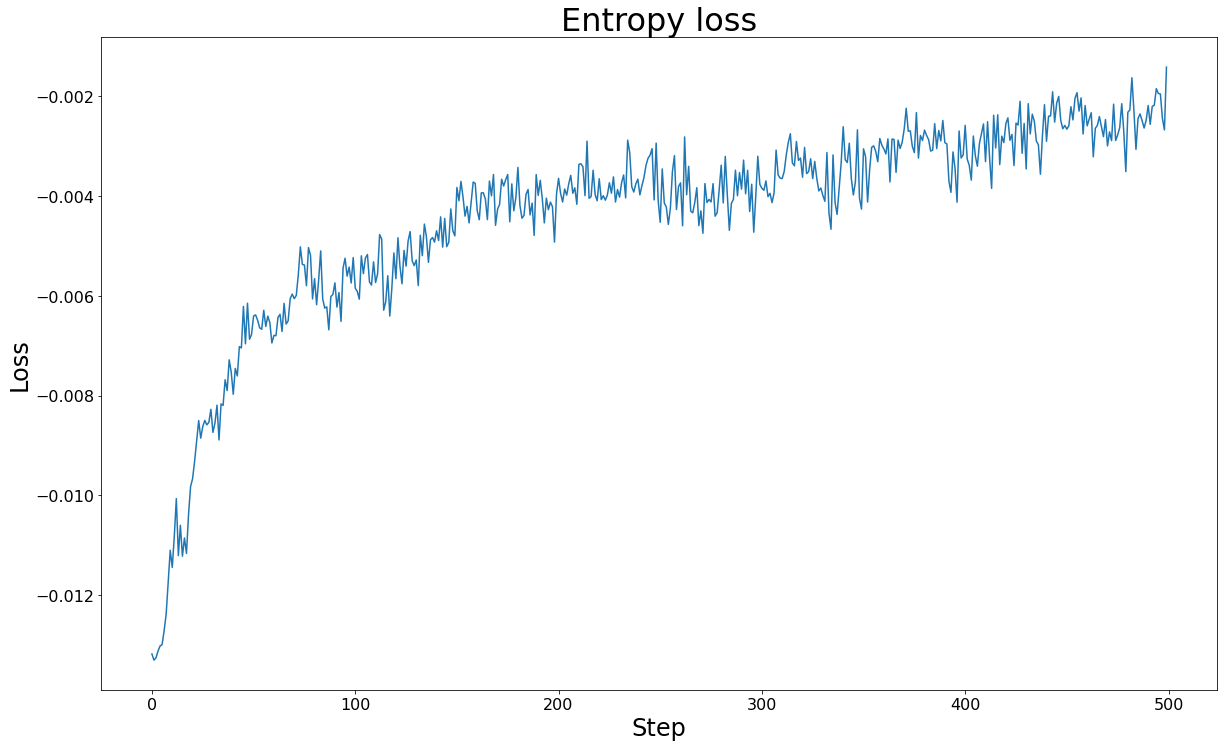

In [34]:
plt.plot(entropy_losses)
plt.title('Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Step');
# plt.yscale('log')

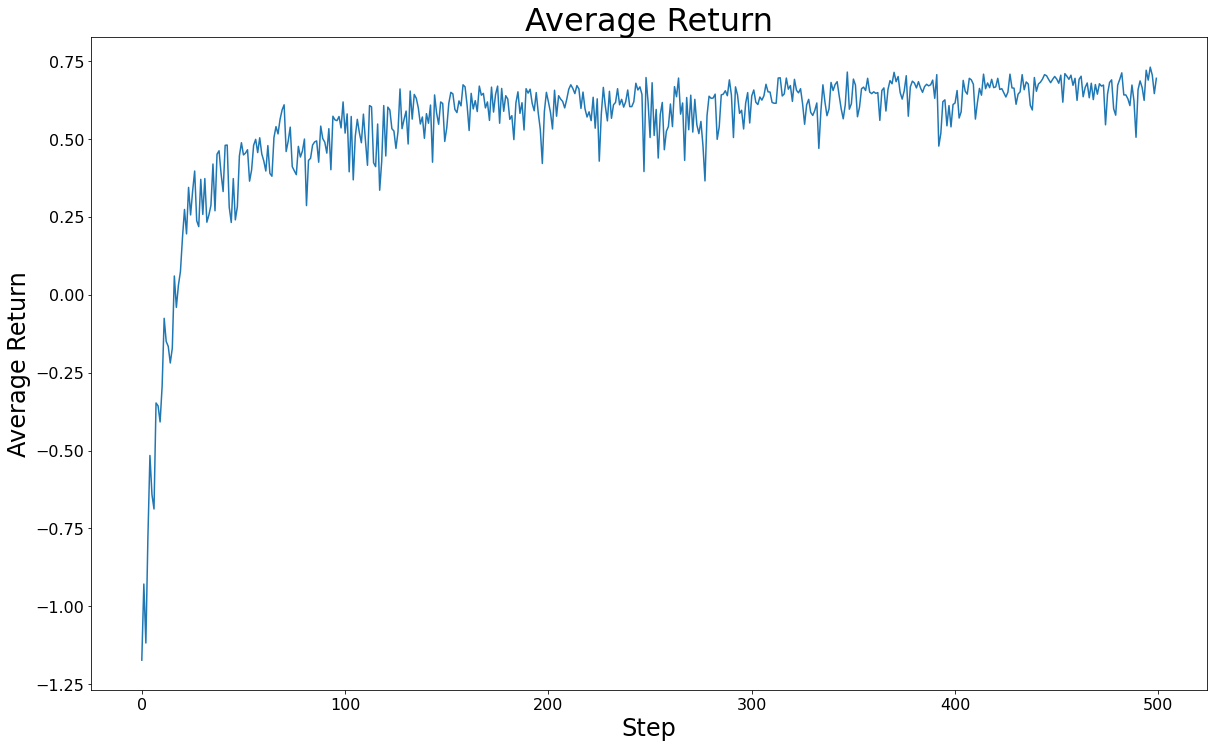

In [35]:
plt.plot(returns)
plt.title('Average Return')
plt.ylabel('Average Return')
plt.xlabel('Step');


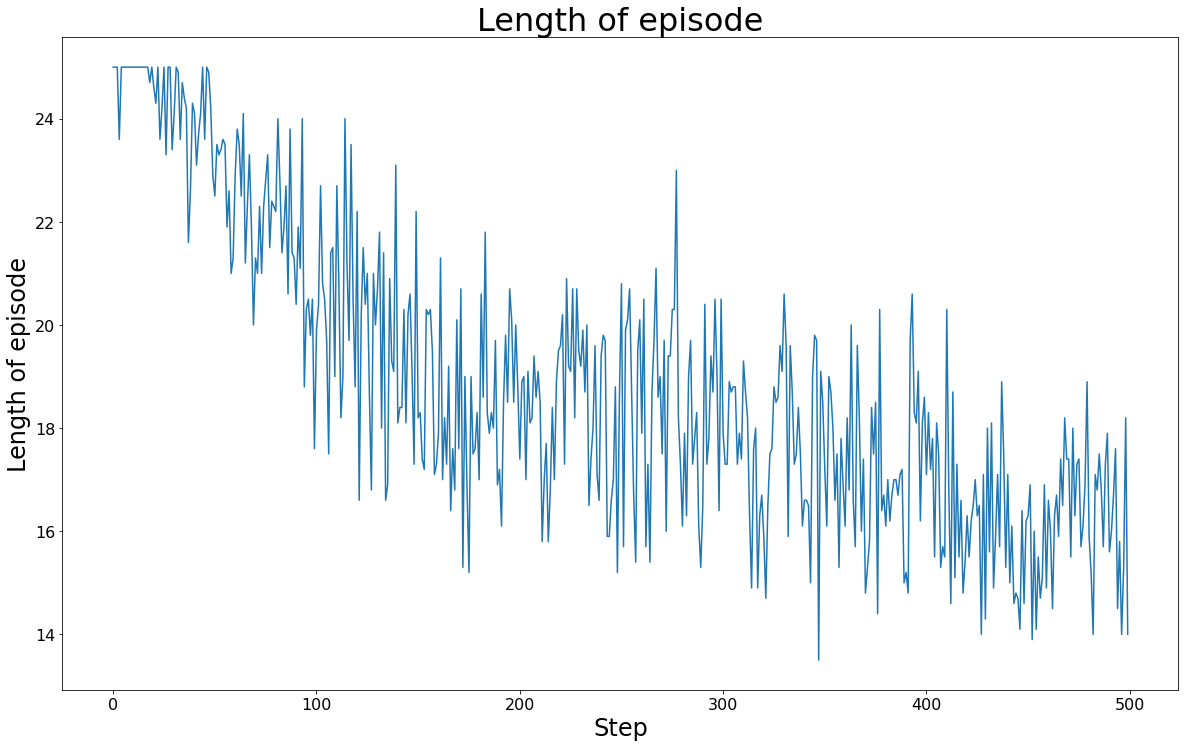

In [36]:
plt.plot(lengths)
plt.title('Length of episode')
plt.ylabel('Length of episode')
plt.xlabel('Step');


# Step VII: In the end all that matters is the policy

<img src='https://djcordhose.github.io/ml-workshop/img/rl/rl-train-play-2.png'>

In [37]:
# https://www.tensorflow.org/agents/tutorials/10_checkpointer_policysaver_tutorial

import os
from tf_agents.policies import policy_saver

tf_policy_saver = policy_saver.PolicySaver(tf_ppo_agent.policy)
tf_policy_saver.save('policy')

INFO:tensorflow:Assets written to: policy/assets


INFO:tensorflow:Assets written to: policy/assets


In [38]:
!ls -l policy

total 168
drwxr-xr-x 2 olli olli   4096 Aug 14 20:50 assets
-rw-r--r-- 1 olli olli   3364 Nov 14 09:30 policy_specs.pbtxt
-rw-r--r-- 1 olli olli 159155 Nov 14 09:30 saved_model.pb
drwxr-xr-x 2 olli olli   4096 Nov 14 09:30 variables


In [39]:
saved_policy = tf.saved_model.load('policy')
saved_policy

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f815c3d1e80>

In [40]:
time_step = eval_env.reset()
while not time_step.is_last():
  action_step = saved_policy.action(time_step)
  print(action_step.action.numpy()[0])  
  time_step = eval_env.step(action_step.action)

2
2
2
1
1
0
1
0
1
2
3
0
0


In [41]:
import base64
import imageio
import IPython

num_episodes = 1
fps=2

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=fps) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = saved_policy.action(time_step)
#       print(action_step.action.numpy()[0])  
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)